<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/admission.png?raw=true" width=800 align="left"/>

# 실습 내용

- Admission 데이터로 모델링합니다.
- SVM 알고리즘으로 모델링합니다.


# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

In [3]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/admission_simple.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [4]:
# 상위 몇 개 행 확인
data.head()

,GRE,TOEFL,RANK,SOP,LOR,GPA,RESEARCH,ADMIT
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,0
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0


In [5]:
# 기술통계 확인
data.describe()

,GRE,TOEFL,RANK,SOP,LOR,GPA,RESEARCH,ADMIT
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.436000
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.496384
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.000000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,1.000000


In [6]:
# 범주값 개수 확인
data['ADMIT'].value_counts()

0    282
1    218
Name: ADMIT, dtype: int64

In [7]:
# 변수 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GRE       500 non-null    int64  
 1   TOEFL     500 non-null    int64  
 2   RANK      500 non-null    int64  
 3   SOP       500 non-null    float64
 4   LOR       500 non-null    float64
 5   GPA       500 non-null    float64
 6   RESEARCH  500 non-null    int64  
 7   ADMIT     500 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 31.4 KB


In [8]:
# 상관관계 확인
data.corr()

,GRE,TOEFL,RANK,SOP,LOR,GPA,RESEARCH,ADMIT
GRE,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.701671
TOEFL,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.680503
RANK,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.618367
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.606876
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.536527
GPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.752196
RESEARCH,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.503104
ADMIT,0.701671,0.680503,0.618367,0.606876,0.536527,0.752196,0.503104,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) x, y 분리**

- target 변수를 명확히 지정합니다.
- target을 제외한 변수를 x 데이터프레임으로 선언합니다.
- y 데이터프레임은 target 변수만을 가집니다.

In [9]:
# target 확인
target = 'ADMIT'

# 데이터 분리
# x = data.drop(target, axis=1)
# 'GRE', 'GPA' 열만 x 변수로 설정
x = data[['GRE', 'GPA']]
y = data[target]

**2) 학습용, 평가용 데이터 분리**

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.
- 반복 실행 시 동일한 결과를 얻기 위해 random_state 옵션을 지정합니다.

In [10]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)  

**3) 정규화**

- SVM 알고리즘을 사용하기 위해 정규화를 진행합니다.
- 마진이 거리가 좋아하기에 정규화해야한다.

In [11]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)


# 4.모델링

- 본격적으로 모델을 선언하고 학습하고 평가하는 과정을 진행합니다.

In [25]:
# 1단계: 불러오기
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

In [26]:
# 2단계: 선언하기
model = SVC(kernel = 'linear', C =1)
# model = SVC(kernel = 'rdf', C =1)

In [27]:
# 3단계: 학습하기
model.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [28]:
# 4단계: 예측하기
y_pred = model.predict(x_test)

In [29]:
# 5단계 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[78  6]
 [ 8 58]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        84
           1       0.91      0.88      0.89        66

    accuracy                           0.91       150
   macro avg       0.91      0.90      0.90       150
weighted avg       0.91      0.91      0.91       150



# 5.기타

- 기타 필요한 내용이 있으면 진행합니다.

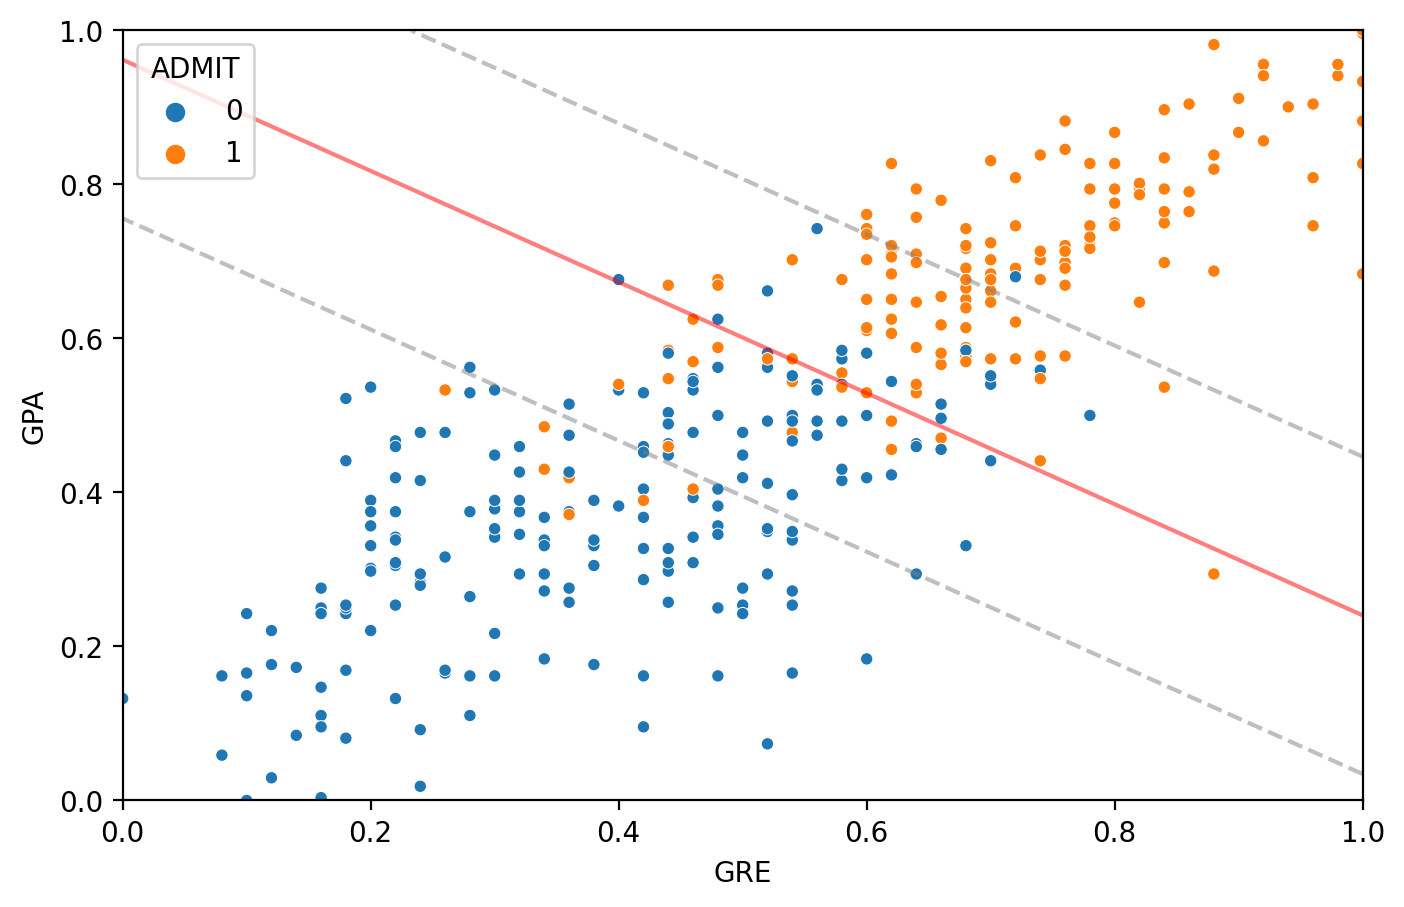

In [19]:
#  시각화
xx = np.linspace(0, 1, 30)
yy = np.linspace(0, 1, 30)
yy, xx = np.meshgrid(yy, xx)
xy = np.vstack([xx.ravel(), yy.ravel()]).T
z = model.decision_function(xy).reshape(xx.shape)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=x_train[:,0], y=x_train[:, 1], hue=y_train, s=20)
# plt.scatter(model.support_vectors_[:, 0], 
#             model.support_vectors_[:, 1], 
#             s=50,
#             linewidth=0.5,
#             facecolors='none', 
#             color='r')
plt.contour(xx, yy, z, 
            levels=[-1, 0, 1], 
            alpha=0.5,
            colors=['gray', 'red', 'gray'],
            linestyles=['--', '-', '--'])

plt.xlabel('GRE')
plt.ylabel('GPA')
plt.show()